# Fidelity Optimization Based on QuCT

**Author:** Congliang Lang & Siwei Tan  

**Date:** 7/4/2024

Based on paper "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features][1]" (MICRO 2023)

[1]: https://dl.acm.org/doi/10.1145/3613424.3614274

In [1]:
import os
os.chdir("..")
import sys
sys.path.append('..')
import logging
logging.basicConfig(level=logging.WARN)

import random
import ray
ray.init(log_to_driver=False)

from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.simulator.gate_error_model import GateErrorModel

from janusq.analysis.vectorization import RandomwalkModel

from janusq.data_objects.random_circuit import random_circuits
from janusq.data_objects.backend import FullyConnectedBackend

from janusq.simulator.noisy_simulator import NoisySimulator

from janusq.tools.ray_func import map

2025-01-09 18:58:02,610	INFO worker.py:1724 -- Started a local Ray instance.


# Noise Optimization Based on QuCT


**Author:** Congliang Lang \& Siwei Tan  

**Date:** 7/4/2024

Based on "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features (MICRO 2023][1]"

[1]: https://scholar.google.com/scholar_url?url=https://dl.acm.org/doi/abs/10.1145/3613424.3614274%3Fcasa_token%3DffjIB1hQ4ZwAAAAA:8MajDLrDOC74WoeMf7r7AoQ-koxCa4E1TNqQg3GSDz03xUX6XdE3toNTM-YdM_e4rKEusMceJ6BGJg&hl=zh-CN&sa=T&oi=gsb&ct=res&cd=0&d=11146218754516883150&ei=42YSZpPlFL6s6rQPtt6x6Ac&scisig=AFWwaeYaiu2hyx8HUJ_7Buf9Mwom

The accurate fidelity prediction enables QuCT to guide the noise optimization. In this notebook, we introduce the optimization strategies.

In [2]:
# build a simulator

n_qubits = 5
n_steps = 1
n_walks = 20
backend = FullyConnectedBackend(n_qubits)

circuits = random_circuits(backend, n_circuits=50, n_gate_list=list(range(10, 150, 10)), two_qubit_prob_list=[0.3, 0.4, 0.6], reverse=True)
up_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
up_model.train(circuits, multi_process=False, remove_redundancy = False)

all_paths = up_model.all_paths()
high_error_paths = random.choices(all_paths, k = 20)

error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = up_model

simulator = NoisySimulator(backend=backend, gate_error_model = error_model)

100%|██████████| 84/84 [00:00<00:00, 197.55it/s]


In [3]:
# train a fidelity model
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=False, multi_process=False)

fidelity_model = FidelityModel(up_model)
fidelity_model.train((circuits, ground_truth_fidelities))

67it [00:00, 652014.77it/s]
17it [00:00, 321185.44it/s]


epoch: 100, 	 epoch loss = 6.603154182434082, 	 validation loss = 0.7545537948608398
epoch: 200, 	 epoch loss = 1.5930513143539429, 	 validation loss = 0.27234703302383423
epoch: 300, 	 epoch loss = 0.6379082202911377, 	 validation loss = 0.227732315659523
epoch: 400, 	 epoch loss = 0.28282949328422546, 	 validation loss = 0.2158118337392807
finish taining with 429 epoch


{'circuit_bias': Array([-25.996347], dtype=float32),
 'gate_params': Array([[8.56070900e+00, 0.00000000e+00, 1.01876335e+01, 3.84065700e+00,
         7.65420151e+00, 0.00000000e+00, 6.52831411e+00, 1.23310347e+01,
         0.00000000e+00, 1.06876259e+01, 3.83904529e+00, 0.00000000e+00,
         3.01716971e+00, 1.43618643e+00, 6.11124468e+00, 2.79243159e+00,
         4.67849541e+00, 7.65895176e+00, 1.41613674e+01, 1.01708050e+01,
         0.00000000e+00, 4.78182268e+00, 6.89649582e+00, 6.33966732e+00,
         8.12528038e+00, 7.52784729e+00, 5.47617626e+00, 1.22318258e+01,
         7.61039877e+00, 6.03664112e+00, 1.34964359e+00, 0.00000000e+00,
         4.34381866e+00, 1.02006521e+01, 1.30769434e+01, 0.00000000e+00,
         3.33549428e+00, 7.09749460e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [2.95067072e+00, 8.51592255e+00, 2.74381280e+00, 0.00000000e+00,
         2.25233698e+00, 1.23278360e+01, 6.44571447e+00, 0.00000000e+00,
         0.00000000e+00, 8.887

In [4]:
# generate a set of benchmarking circuits

from janusq.data_objects.algorithms import get_algorithm_circuits
from janusq.optimizations.scheduling.scheduling_ct import Scheduler
from janusq.optimizations.mapping.mapping_ct import Mapper
algs = ['qft', 'hs', 'ising', 'qknn', 'qsvm', 'vqc', 'grover']
benchmarking_circuits = get_algorithm_circuits(n_qubits, backend, algs)

/Users/chutianyao/anaconda3/envs/janusq/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chutianyao/anaconda3/envs/janusq/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


## Scheduling

We can use Janus-CT to guide the scheduling.

In [5]:
scheduler = Scheduler(fidelity_model)

baseline_fidelities, opt_fidelities = [], []
for circuit in benchmarking_circuits:
    baseline_fidelities.append(simulator.obtain_circuit_fidelity(circuit)[0])
    
    opt_circuit = scheduler.run(circuit, timeout=60)
    opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    
    opt_fidelities.append(opt_fidelity)
    print('before scheduling: ', baseline_fidelities[-1], 'after scheduling: ', opt_fidelities[-1])

before scheduling:  0.9694583006311561 after scheduling:  0.9795045499459926
before scheduling:  0.9765367956887477 after scheduling:  0.9757208909020327
before scheduling:  0.9792671650533176 after scheduling:  0.9800286423454228
before scheduling:  0.9657057836040606 after scheduling:  0.9764709053873476
before scheduling:  0.966449447493346 after scheduling:  0.9745429553124276
before scheduling:  0.9229912551421154 after scheduling:  0.9140007943251224
before scheduling:  0.8480812074215802 after scheduling:  0.8785230849999538


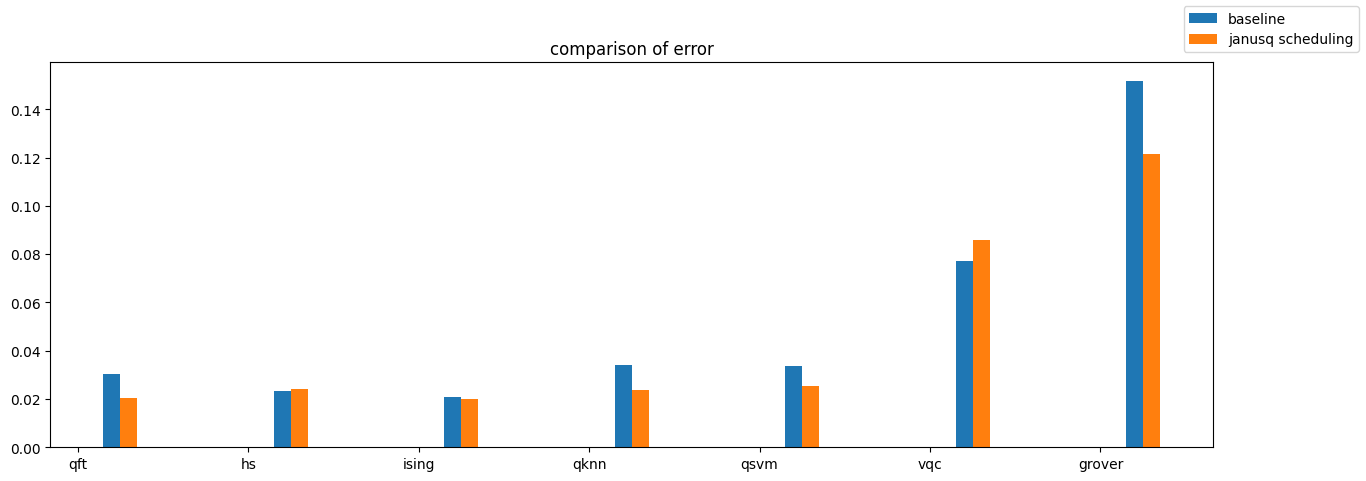

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(figsize=(15, 5))
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')


baseline_fidelities = np.array(baseline_fidelities)
opt_fidelities = np.array(opt_fidelities)
axes.bar(x+4,1-baseline_fidelities,width =2,label='baseline')
axes.bar(x+6,1-opt_fidelities,width =2,label='janusq scheduling')

plt.title('comparison of error')
axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()